# Classificação Binária da presença de fogo em imagens com Yolov11

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
#Importe das bibliotecas necessárias
import os
import random
import shutil
from pathlib import Path
import yaml
from ultralytics import YOLO
import kagglehub

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Etapa 0: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho do projeto no Drive
drive_base = Path("/content/drive/MyDrive/Yolo_Fire_Project")
output_dataset_path = drive_base / "dataset"
yaml_path = output_dataset_path / "data.yaml"

Mounted at /content/drive


In [4]:
# Etapa 1: Baixar o dataset
path = kagglehub.dataset_download("phylake1337/fire-dataset")
original_dataset_path = Path(path) / "fire_dataset"


100%|██████████| 387M/387M [00:03<00:00, 129MB/s]

Extracting files...


In [5]:
# Mapear nomes das pastas reais para rótulos
dataset_dirs = {
    "fire": "fire_images",
    "non_fire": "non_fire_images"
}
classes = list(dataset_dirs.keys())


# Etapa 2: Criar estrutura de pastas
def create_folders():
    for split in ["train", "val", "test"]:
        for cls in classes:
            (output_dataset_path / split / cls).mkdir(parents=True, exist_ok=True)


In [6]:
# Etapa 3: Copiar e dividir imagens
def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "As proporções devem somar 1.0"

    class_map = {
        "fire_images": "fire",
        "non_fire_images": "non_fire"
    }

    for folder_name, class_name in class_map.items():
        class_path = Path(source_dir) / folder_name
        images = list(class_path.glob("*.png")) + list(class_path.glob("*.jpg"))
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split, split_images in splits.items():
            split_dir = Path(output_dir) / split / class_name
            split_dir.mkdir(parents=True, exist_ok=True)
            for img_path in split_images:
                shutil.copy(img_path, split_dir)

        print(f"\nClasse '{class_name}':")
        print(f"  Treino: {n_train} imagens")
        print(f"  Validação: {n_val} imagens")
        print(f"  Teste: {n_test} imagens")

In [7]:
# Etapa 4: Criar data.yaml
def create_yaml():
    data = {
        "train": str((output_dataset_path / "train").resolve()),
        "val": str((output_dataset_path / "val").resolve()),
        "test": str((output_dataset_path / "test").resolve()),
        "nc": len(classes),
        "names": classes
    }
    with open(yaml_path, "w") as f:
        yaml.dump(data, f)


In [8]:
# Etapa 5: Verificar distribuição
def show_distribution():
    print("Distribuição de imagens:")
    for split in ["train", "val", "test"]:
        print(f"\n{split.upper()}")
        for cls in classes:
            count = len(list((output_dataset_path / split / cls).glob("*.*")))
            print(f"  {cls}: {count} imagens")

# Etapa 6: Treinar o modelo
def train_model():
    print("\nTreinando o modelo YOLOv11...")
    model = YOLO("yolo11n-cls.pt")
    results = model.train(
        data=output_dataset_path,
        epochs=25,
        imgsz=640,
        optimizer="Adam"
    )

    # Salvar gráficos e matriz de confusão no Drive
    results_dir = drive_base / "results"
    results_dir.mkdir(parents=True, exist_ok=True)

    if Path("results.png").exists():
        shutil.copy("results.png", results_dir)
    if Path("confusion_matrix.png").exists():
        shutil.copy("confusion_matrix.png", results_dir)

    print(f"\nArquivos de resultados salvos em: {results_dir}")
    print("\nTreinamento concluído!")


In [9]:
# Execução principal
if __name__ == "__main__":
    create_folders()
    split_dataset(source_dir=original_dataset_path, output_dir=output_dataset_path)
    create_yaml()
    show_distribution()
    train_model()


Classe 'fire':
  Treino: 528 imagens
  Validação: 113 imagens
  Teste: 114 imagens

Classe 'non_fire':
  Treino: 170 imagens
  Validação: 36 imagens
  Teste: 38 imagens
Distribuição de imagens:

TRAIN
  fire: 528 imagens
  non_fire: 170 imagens

VAL
  fire: 113 imagens
  non_fire: 36 imagens

TEST
  fire: 114 imagens
  non_fire: 38 imagens

Treinando o modelo YOLOv11...


100%|██████████| 5.52M/5.52M [00:00<00:00, 67.5MB/s]


Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Yolo_Fire_Project/dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

100%|██████████| 5.35M/5.35M [00:00<00:00, 102MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.3±0.1 ms, read: 48.9±37.3 MB/s, size: 126.0 KB)


train: Scanning /content/drive/MyDrive/Yolo_Fire_Project/dataset/train... 697 images, 1 corrupt: 100%|██████████| 698/698 [00:04<00:00, 151.99it/s]

train: /content/drive/MyDrive/Yolo_Fire_Project/dataset/train/fire/fire.357.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Yolo_Fire_Project/dataset/train/fire/fire.681.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Yolo_Fire_Project/dataset/train/non_fire/non_fire.189.png: ignoring corrupt image/label: Invalid image format GIF. Supported formats are:
images: {'jpg', 'dng', 'tif', 'png', 'heic', 'jpeg', 'tiff', 'mpo', 'webp', 'pfm', 'bmp'}
videos: {'m4v', 'avi', 'wmv', 'mkv', 'webm', 'mov', 'mpeg', 'gif', 'ts', 'mp4', 'asf', 'mpg'}


train: New cache created: /content/drive/MyDrive/Yolo_Fire_Project/dataset/train.cache
val: Fast image access ✅ (ping: 1.6±2.2 ms, read: 14.8±11.9 MB/s, size: 62.6 KB)


val: Scanning /content/drive/MyDrive/Yolo_Fire_Project/dataset/val... 149 images, 0 corrupt: 100%|██████████| 149/149 [00:02<00:00, 59.11it/s]

val: /content/drive/MyDrive/Yolo_Fire_Project/dataset/val/fire/fire.576.png: corrupt JPEG restored and saved
val: New cache created: /content/drive/MyDrive/Yolo_Fire_Project/dataset/val.cache


optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/25      1.59G     0.8105         16        640:   5%|▍         | 2/44 [00:03<00:54,  1.30s/it]


100%|██████████| 755k/755k [00:00<00:00, 8.51MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]

                   all      0.899          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:06<00:00,  1.32s/it]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      10/25      2.08G     0.1905          9        640: 100%|██████████| 44/44 [00:40<00:00,  1.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:06<00:00,  1.29s/it]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      11/25      2.09G     0.1523          9        640: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      12/25       2.1G      0.172          9        640: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      13/25      2.11G     0.2548          9        640: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


      14/25      2.12G     0.2006          9        640: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      15/25      2.13G     0.1386          9        640: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      16/25      2.14G     0.2229          9        640: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      17/25      2.14G     0.1533          9        640: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      18/25      2.15G     0.1769          9        640: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      19/25      2.16G     0.1406          9        640: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      20/25      2.17G     0.1768          9        640: 100%|██████████| 44/44 [00:57<00:00,  1.30s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      21/25      2.18G     0.1143          9        640: 100%|██████████| 44/44 [00:54<00:00,  1.24s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      22/25      2.19G      0.149          9        640: 100%|██████████| 44/44 [01:09<00:00,  1.57s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


      23/25       2.2G     0.1179          9        640: 100%|██████████| 44/44 [00:47<00:00,  1.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      24/25      2.21G     0.1168          9        640: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      25/25      2.21G     0.1016          9        640: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]

                   all       0.98          1



25 epochs completed in 0.381 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.2MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/Yolo_Fire_Project/dataset/train... found 698 images in 2 classes ✅ 
val: /content/drive/MyDrive/Yolo_Fire_Project/dataset/val... found 149 images in 2 classes ✅ 
test: /content/drive/MyDrive/Yolo_Fire_Project/dataset/test... found 152 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


                   all      0.987          1
Speed: 0.6ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train

Arquivos de resultados salvos em: /content/drive/MyDrive/Yolo_Fire_Project/results

Treinamento concluído!


#Avaliação no conjunto de teste

In [10]:
model = YOLO("runs/classify/train/weights/best.pt")
metrics = model.val(split="test", data=str(yaml_path.resolve()))

Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
test: Fast image access ✅ (ping: 1.9±2.1 ms, read: 20.9±43.5 MB/s, size: 160.3 KB)


test: Scanning /content/drive/MyDrive/Yolo_Fire_Project/dataset/test... 152 images, 0 corrupt: 100%|██████████| 152/152 [00:01<00:00, 79.83it/s]

test: New cache created: /content/drive/MyDrive/Yolo_Fire_Project/dataset/test.cache



               classes   top1_acc   top5_acc: 100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


                   all      0.947          1
Speed: 2.7ms preprocess, 5.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


#Verificar erros de classificação


0: 640x640 fire 1.00, non_fire 0.00, 2.1ms
1: 640x640 fire 1.00, non_fire 0.00, 2.1ms
2: 640x640 fire 1.00, non_fire 0.00, 2.1ms
3: 640x640 fire 1.00, non_fire 0.00, 2.1ms
4: 640x640 fire 1.00, non_fire 0.00, 2.1ms
5: 640x640 fire 1.00, non_fire 0.00, 2.1ms
6: 640x640 fire 1.00, non_fire 0.00, 2.1ms
7: 640x640 fire 1.00, non_fire 0.00, 2.1ms
8: 640x640 fire 1.00, non_fire 0.00, 2.1ms
9: 640x640 fire 0.98, non_fire 0.02, 2.1ms
10: 640x640 fire 1.00, non_fire 0.00, 2.1ms
11: 640x640 fire 1.00, non_fire 0.00, 2.1ms
12: 640x640 fire 1.00, non_fire 0.00, 2.1ms
13: 640x640 fire 1.00, non_fire 0.00, 2.1ms
14: 640x640 fire 0.74, non_fire 0.26, 2.1ms
15: 640x640 fire 1.00, non_fire 0.00, 2.1ms
16: 640x640 fire 1.00, non_fire 0.00, 2.1ms
17: 640x640 fire 1.00, non_fire 0.00, 2.1ms
18: 640x640 fire 1.00, non_fire 0.00, 2.1ms
19: 640x640 fire 1.00, non_fire 0.00, 2.1ms
20: 640x640 fire 0.99, non_fire 0.01, 2.1ms
21: 640x640 fire 1.00, non_fire 0.00, 2.1ms
22: 640x640 fire 1.00, non_fire 0.00, 2.1

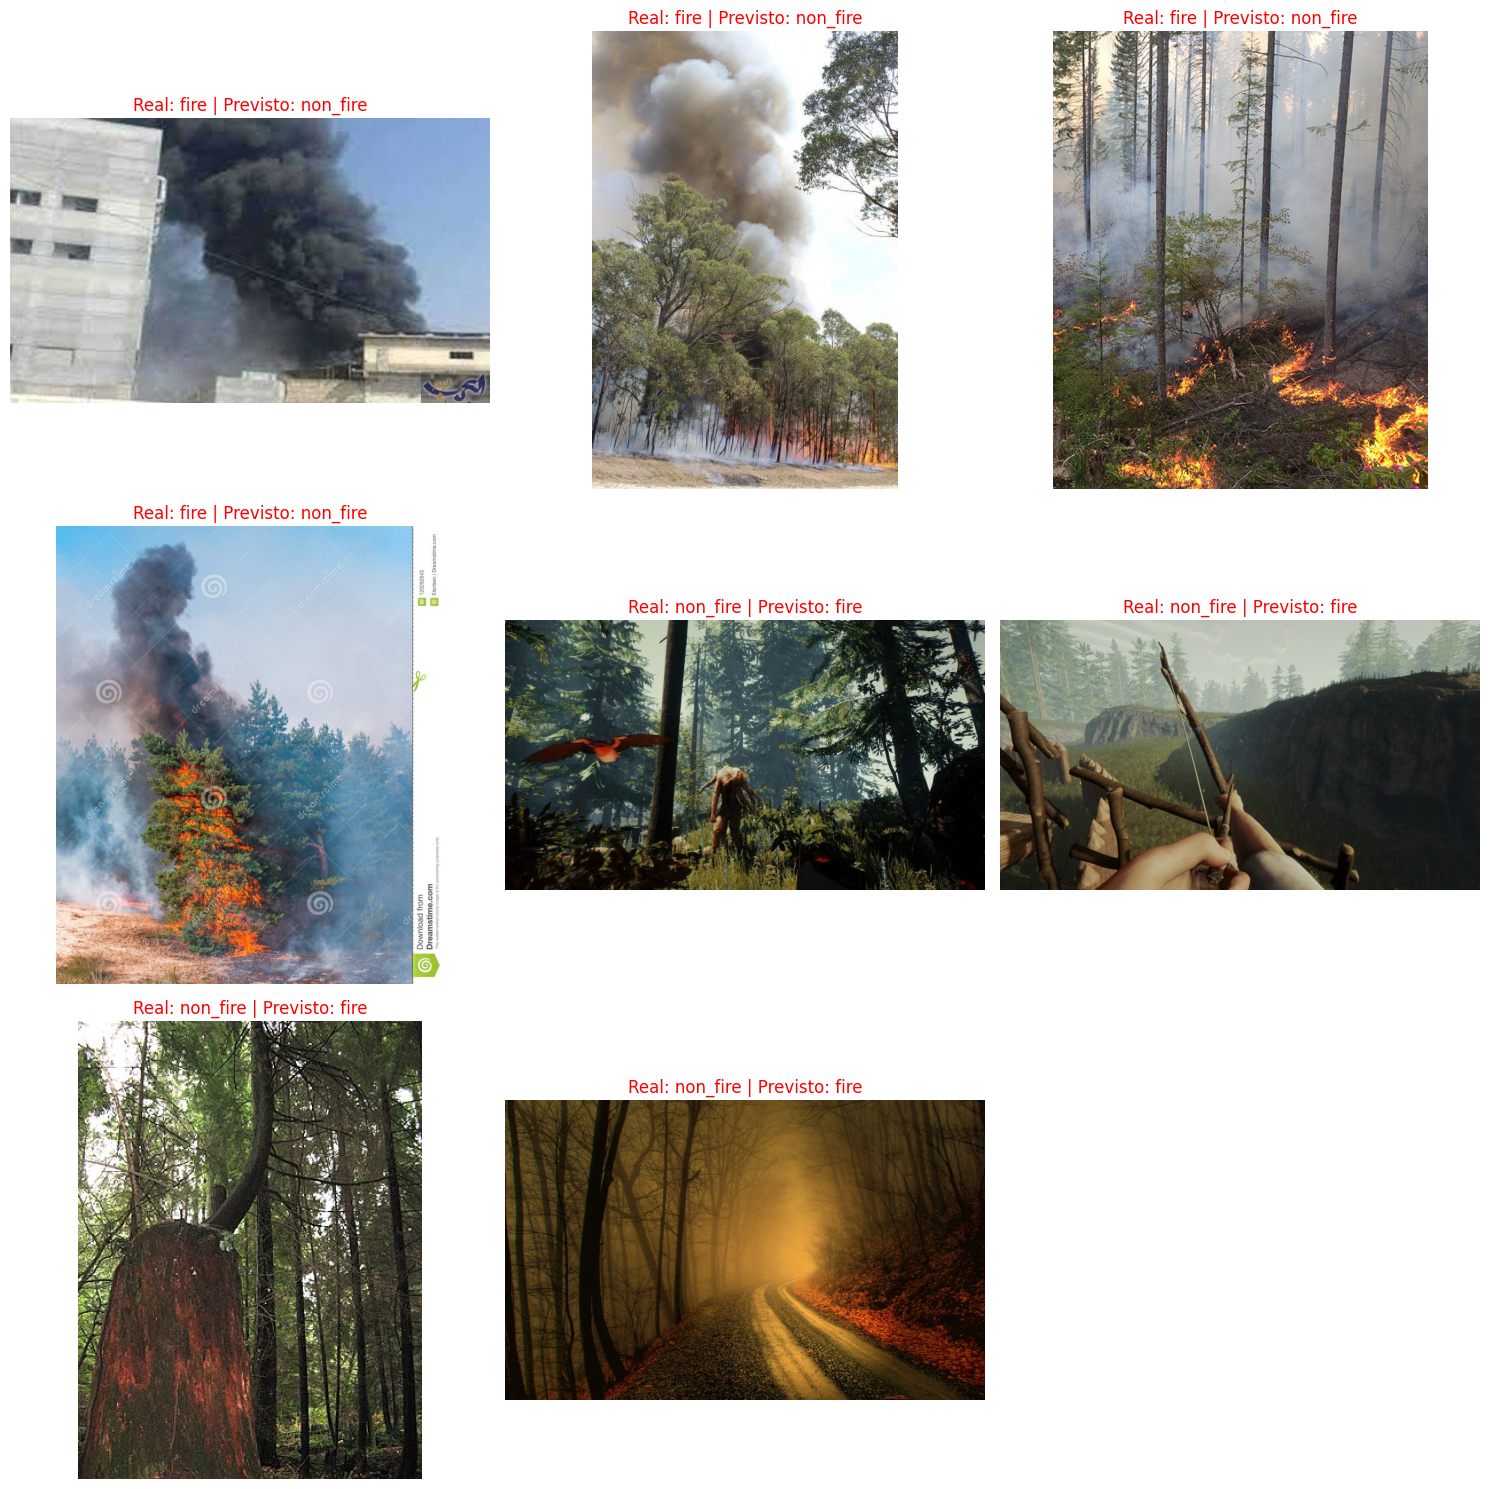

In [12]:
import os
import matplotlib.pyplot as plt
from PIL import Image
# Diretório de teste
test_dir = "/content/drive/MyDrive/Yolo_Fire_Project/dataset/test"

# Listando imagens
fire_images = [os.path.join(test_dir, "fire", f) for f in os.listdir(os.path.join(test_dir, "fire"))]
non_fire_images = [os.path.join(test_dir, "non_fire", f) for f in os.listdir(os.path.join(test_dir, "non_fire"))]
all_images = fire_images + non_fire_images

# Labels reais: 0 para fire, 1 para non_fire
true_labels = [0] * len(fire_images) + [1] * len(non_fire_images)
label_map = {0: "fire", 1: "non_fire"}

# Realiza as predições
results = model.predict(source=all_images, stream=True)

# Coleta predições e exibe erros
errors = []

for r, path, true in zip(results, all_images, true_labels):
    pred = r.probs.top1
    if pred != true:
        errors.append((path, true, pred))

# Exibe as imagens com erro
print(f"Total de erros: {len(errors)}\n")

n = len(errors)
cols = 3
rows = (n + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))
for idx, (path, true, pred) in enumerate(errors):
    img = Image.open(path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(f"Real: {label_map[true]} | Previsto: {label_map[pred]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

# Código para gerar amostra do dataset

In [ ]:
# Caminho base do dataset
base_path = "/content/drive/MyDrive/Yolo_Fire_Project/dataset"

# Função para exibir imagens de uma classe em uma subdivisão
def show_images(subset, class_name, num_images=5):
    path = os.path.join(base_path, subset, class_name)
    images = os.listdir(path)
    selected = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{subset}/{class_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Exibir imagens de todas as divisões e classes
for subset in ["train", "val", "test"]:
    for class_name in ["fire", "non_fire"]:
        show_images(subset, class_name)